# Internal Validation Notebook

This notebook tests the end-to-end functionality of the `simba_plus.discovery` module.

**Goal:** Validate that the following modules work together correctly:
1. `candidate_links.py` — candidate peak–gene link generation  
2. `build_evalset.py` — evaluation set construction (CRISPR / eQTL)  
3. `add_features.py` — SIMBA+ feature computation  

**Note:** This notebook is for internal testing only and is not part of the public demo.


In [20]:
import sys, os
sys.path.append(os.path.abspath("../src"))
import importlib
from simba_plus.discovery import candidate_links, build_evalset, add_features, model_training, plot_utils

importlib.reload(candidate_links)
importlib.reload(build_evalset)
importlib.reload(add_features)
importlib.reload(model_training)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import numpy as np

os.makedirs("../data/reference", exist_ok=True)
os.makedirs("../data/validation", exist_ok=True)
os.makedirs("../data/results", exist_ok=True)


## 1️⃣ Candidate Link Generation
Test reading TSS BED file and generating candidate peak–gene pairs.


In [2]:
# --- For RNA (adata_CG) ---
adata_CG = ad.read_h5ad('/data/pinello/PROJECTS/2022_12_GCPA/data/multiome/BMMC/adata_CG.h5ad')

# compute % of cells where gene is expressed
n_cells = (adata_CG.X >= 1).sum(axis=0).A1
adata_CG.var['n_cells'] = n_cells
adata_CG.var['pct_cells'] = n_cells/adata_CG.shape[0]

# filter genes expressed in >5% of cells
fivepct_genes = adata_CG.var_names[adata_CG.var["pct_cells"] > 0.05]

# --- For ATAC (adata_CP) ---
adata_CP = ad.read_h5ad('/data/pinello/PROJECTS/2022_12_GCPA/data/multiome/BMMC/adata_CP.h5ad')

# compute % of cells where each peak is accessible
n_cells = (adata_CP.X >= 1).sum(axis=0).A1
adata_CP.var['n_cells'] = n_cells
adata_CP.var['pct_cells'] = n_cells/adata_CP.shape[0]

# filter peaks accessible in >5% of cells
fivepct_peaks = adata_CP.var_names[adata_CP.var["pct_cells"] > 0.05]

In [3]:
candidates = candidate_links.get_peak_gene_links(fivepct_peaks, fivepct_genes, cis_window=500000)
candidates.head()


Parsing peaks: 100%|██████████| 16127/16127 [00:00<00:00, 946578.33it/s]

Finding TSS–peak overlaps...


,Gene_name,Gene_ID,Peak,Distance_to_TSS,TSS,peak_gene_pair
291,ISG15,ENSG00000187608,chr1_629497_630394,383271,1013216,chr1_629497_630394_ISG15
292,ISG15,ENSG00000187608,chr1_633515_634474,379222,1013216,chr1_633515_634474_ISG15
293,ISG15,ENSG00000187608,chr1_778276_779191,234483,1013216,chr1_778276_779191_ISG15
294,ISG15,ENSG00000187608,chr1_827067_827948,185709,1013216,chr1_827067_827948_ISG15
295,ISG15,ENSG00000187608,chr1_869472_870377,143292,1013216,chr1_869472_870377_ISG15


## 2️⃣ CRISPR Evaluation Set Construction

In [14]:
# === Output Paths ===
candidate_csv = "../data/validation/test_candidates.csv"
crispr_file = "../data/reference/EPCrisprBenchmark_combined_data.training_K562.GRCh38.tsv.gz"
crispr_eval_csv = "../data/validation/test_crispr_eval.csv"

# Save candidate links from previous section
candidates.to_csv(candidate_csv, index=False)

# === Build CRISPR evaluation set ===
crispr_eval_df = build_evalset.build_crispr_evalset(
    candidate_csv=candidate_csv,
    crispr_file=crispr_file,
    output_csv=crispr_eval_csv
)

Building CRISPR evaluation set...
Intersecting CRISPR elements with candidate peaks...


In [15]:
crispr_eval_df.shape

(519, 13)

In [6]:
crispr_eval_df.head()

,crispr_chrom,crispr_start,crispr_end,crispr_gene,crispr_regulated,peak_chrom,peak_start,peak_end,Peak,Gene,Distance_to_TSS,label,1/Distance
0,chr1,23539621,23540248,RPL11,False,chr1,23539506,23540419,chr1_23539506_23540419,RPL11,151566,0,0.000007
1,chr1,23554642,23555320,RPL11,False,chr1,23554523,23555411,chr1_23554523_23555411,RPL11,136561,0,0.000007
2,chr1,26377523,26378866,HMGN2,False,chr1,26378065,26378966,chr1_26378065_26378966,HMGN2,93645,0,0.000011
3,chr1,26500769,26501550,HMGN2,False,chr1,26500803,26501180,chr1_26500803_26501180,HMGN2,28831,0,0.000035
4,chr1,26377523,26378866,SH3BGRL3,False,chr1,26378065,26378966,chr1_26378065_26378966,SH3BGRL3,99044,0,0.000010


## 3️⃣ Add SIMBA+ Path Score

In [21]:
# === Paths to SIMBA+ embeddings ===
adata_C_path = "/data/pinello/PROJECTS/2022_12_GCPA/runs/multiome/BMMC/pl_20240909_bmmc_multiome_raw_batched_1M_prox.noproj.indep2_1e-02.randinit.checkpoints/adata_C.h5ad"
adata_G_path = "/data/pinello/PROJECTS/2022_12_GCPA/runs/multiome/BMMC/pl_20240909_bmmc_multiome_raw_batched_1M_prox.noproj.indep2_1e-02.randinit.checkpoints/adata_G.h5ad"
adata_P_path = "/data/pinello/PROJECTS/2022_12_GCPA/runs/multiome/BMMC/pl_20240909_bmmc_multiome_raw_batched_1M_prox.noproj.indep2_1e-02.randinit.checkpoints/adata_P.h5ad"

# === Run feature addition ===
crispr_eval_with_features = add_features.add_simba_plus_features(
    eval_df=crispr_eval_df,
    adata_C_path=adata_C_path,
    adata_G_path=adata_G_path,
    adata_P_path=adata_P_path,
    gene_col="Gene",
    peak_col="Peak",
)

/data/pinello/PROJECTS/2023_09_JF_SIMBAvariant/simba-plus/src/simba_plus/discovery/add_features.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_col: str,
/data/pinello/PROJECTS/2023_09_JF_SIMBAvariant/simba-plus/src/simba_plus/discovery/add_features.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_col: str,


Computing global SIMBA+ path scores...


In [ ]:
crispr_eval_with_features['peak_gene_pair'] = crispr_eval_with_features['Peak'] + '_' + crispr_eval_with_features['Gene']
crispr_eval_with_features.drop_duplicates('peak_gene_pair',inplace=True) # drop duplicates because a peak might overlap multiple elements from crispr eval set

In [23]:
crispr_eval_with_features.head()

,crispr_chrom,crispr_start,crispr_end,crispr_gene,crispr_regulated,peak_chrom,peak_start,peak_end,Peak,Gene,Distance_to_TSS,label,1/Distance,SIMBA+_path_score,peak_gene_pair
0,chr1,23539621,23540248,RPL11,False,chr1,23539506,23540419,chr1_23539506_23540419,RPL11,151566,0,0.000007,1.002100,chr1_23539506_23540419_RPL11
1,chr1,23554642,23555320,RPL11,False,chr1,23554523,23555411,chr1_23554523_23555411,RPL11,136561,0,0.000007,1.014952,chr1_23554523_23555411_RPL11
2,chr1,26377523,26378866,HMGN2,False,chr1,26378065,26378966,chr1_26378065_26378966,HMGN2,93645,0,0.000011,0.989798,chr1_26378065_26378966_HMGN2
3,chr1,26500769,26501550,HMGN2,False,chr1,26500803,26501180,chr1_26500803_26501180,HMGN2,28831,0,0.000035,0.995827,chr1_26500803_26501180_HMGN2
4,chr1,26377523,26378866,SH3BGRL3,False,chr1,26378065,26378966,chr1_26378065_26378966,SH3BGRL3,99044,0,0.000010,0.984362,chr1_26378065_26378966_SH3BGRL3


In [13]:
crispr_eval_with_features.to_csv("../data/validation/crispr_eval_with_features.csv", index=False)

In [2]:
crispr_eval_with_features = pd.read_csv("../data/validation/crispr_eval_with_features.csv")

## 4️⃣ Model training

In [ ]:
# in manuscript, model is trained 5 times with different random seeds: seeds = [1, 2, 3, 4, 5] and n_search_iter=60
# prediction prob averaged across 5 runs for final visualization

In [ ]:
feature_sets = {
    "simba_plus_distance": ["SIMBA+_path_score", "1/Distance"],
    "distance_only": ["1/Distance"],
    "simba_plus_only": ["SIMBA+_path_score"],
}

results = model_training.train_xgboost(
        df=crispr_eval_with_features,
        dataset_name="crispr",
        output_dir="../results/xgb_models",
        feature_sets=feature_sets,
        n_search_iter=30,
        search_n_jobs=8,
        random_state=1
    )


Preprocessing dataset 'crispr'...
Starting training for 3 model(s)...

=== Training model: simba_plus_distance ===
[LOCO] Holding out chr1 for validation
  ↳ Best params: {'subsample': 0.6, 'scale_pos_weight': 12.567567567567568, 'reg_lambda': 30, 'reg_alpha': 0.5, 'random_state': 42, 'n_jobs': 1, 'n_estimators': 3000, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.02, 'gamma': 2, 'colsample_bytree': 0.6}
[LOCO] Holding out chr10 for validation
  ↳ Best params: {'subsample': 0.6, 'scale_pos_weight': 12.567567567567568, 'reg_lambda': 3, 'reg_alpha': 3, 'random_state': 42, 'n_jobs': 1, 'n_estimators': 5000, 'min_child_weight': 10, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}
[LOCO] Holding out chr11 for validation
  ↳ Best params: {'subsample': 1.0, 'scale_pos_weight': 12.567567567567568, 'reg_lambda': 30, 'reg_alpha': 1, 'random_state': 42, 'n_jobs': 1, 'n_estimators': 9000, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.03, 'gamma'

/data/pinello/SHARED_SOFTWARE/envs/jf1144_envs/jf_simba_variant/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:26:29] WARNING: /workspace/src/metric/auc.cc:320: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)


Saved 13 folds → ../results/xgb_models

=== Training model: distance_only ===
[LOCO] Holding out chr1 for validation
  ↳ Best params: {'subsample': 1.0, 'scale_pos_weight': 12.567567567567568, 'reg_lambda': 30, 'reg_alpha': 0, 'random_state': 42, 'n_jobs': 1, 'n_estimators': 5000, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.03, 'gamma': 0.5, 'colsample_bytree': 0.8}
[LOCO] Holding out chr10 for validation
  ↳ Best params: {'subsample': 0.8, 'scale_pos_weight': 12.567567567567568, 'reg_lambda': 30, 'reg_alpha': 0.5, 'random_state': 42, 'n_jobs': 1, 'n_estimators': 9000, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.03, 'gamma': 1.5, 'colsample_bytree': 0.6}
[LOCO] Holding out chr11 for validation
  ↳ Best params: {'subsample': 1.0, 'scale_pos_weight': 12.567567567567568, 'reg_lambda': 3, 'reg_alpha': 1, 'random_state': 42, 'n_jobs': 1, 'n_estimators': 3000, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 2, 'colsample_bytree': 0.6}
[LOCO]

/data/pinello/SHARED_SOFTWARE/envs/jf1144_envs/jf_simba_variant/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:28:35] WARNING: /workspace/src/metric/auc.cc:320: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)


Saved 13 folds → ../results/xgb_models

=== Training model: simba_plus_only ===
[LOCO] Holding out chr1 for validation
  ↳ Best params: {'subsample': 0.6, 'scale_pos_weight': 12.567567567567568, 'reg_lambda': 3, 'reg_alpha': 3, 'random_state': 42, 'n_jobs': 1, 'n_estimators': 5000, 'min_child_weight': 10, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.6}
[LOCO] Holding out chr10 for validation
  ↳ Best params: {'subsample': 1.0, 'scale_pos_weight': 12.567567567567568, 'reg_lambda': 30, 'reg_alpha': 0, 'random_state': 42, 'n_jobs': 1, 'n_estimators': 6000, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.03, 'gamma': 1, 'colsample_bytree': 1.0}
[LOCO] Holding out chr11 for validation
  ↳ Best params: {'subsample': 1.0, 'scale_pos_weight': 12.567567567567568, 'reg_lambda': 1, 'reg_alpha': 0, 'random_state': 42, 'n_jobs': 1, 'n_estimators': 9000, 'min_child_weight': 10, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 1.5, 'colsample_bytree': 1.0}
[LOCO

/data/pinello/SHARED_SOFTWARE/envs/jf1144_envs/jf_simba_variant/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:30:48] WARNING: /workspace/src/metric/auc.cc:320: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)


Saved 13 folds → ../results/xgb_models

Saved summary → ../results/xgb_models/results.pkl
Reloading saved results for summary...

 Finished full pipeline for 'crispr'
  - Models saved to: ../results/xgb_models
  - Metrics shape: (39, 10)
  - Predictions shape: (446, 6)


In [ ]:
# quickly load results if needed
from simba_plus.discovery.model_training import load_results

results_obj, metrics_df, preds_df = load_results(
    "/data/pinello/PROJECTS/2023_09_JF_SIMBAvariant/simba-plus/results/xgb_models"
)

## 5️⃣ Plotting

In [4]:
# Customizable labels and columns
columns_and_labels = [
    ('SIMBA+ path score + 1/Distance', 'pred_prob_simba_plus_distance'),
    ('SIMBA+ path score only', 'pred_prob_simba_plus_only'),
    ('1/Distance', 'pred_prob_distance_only'),
]

Saved figure → ../results/crispr_supervised.pdf


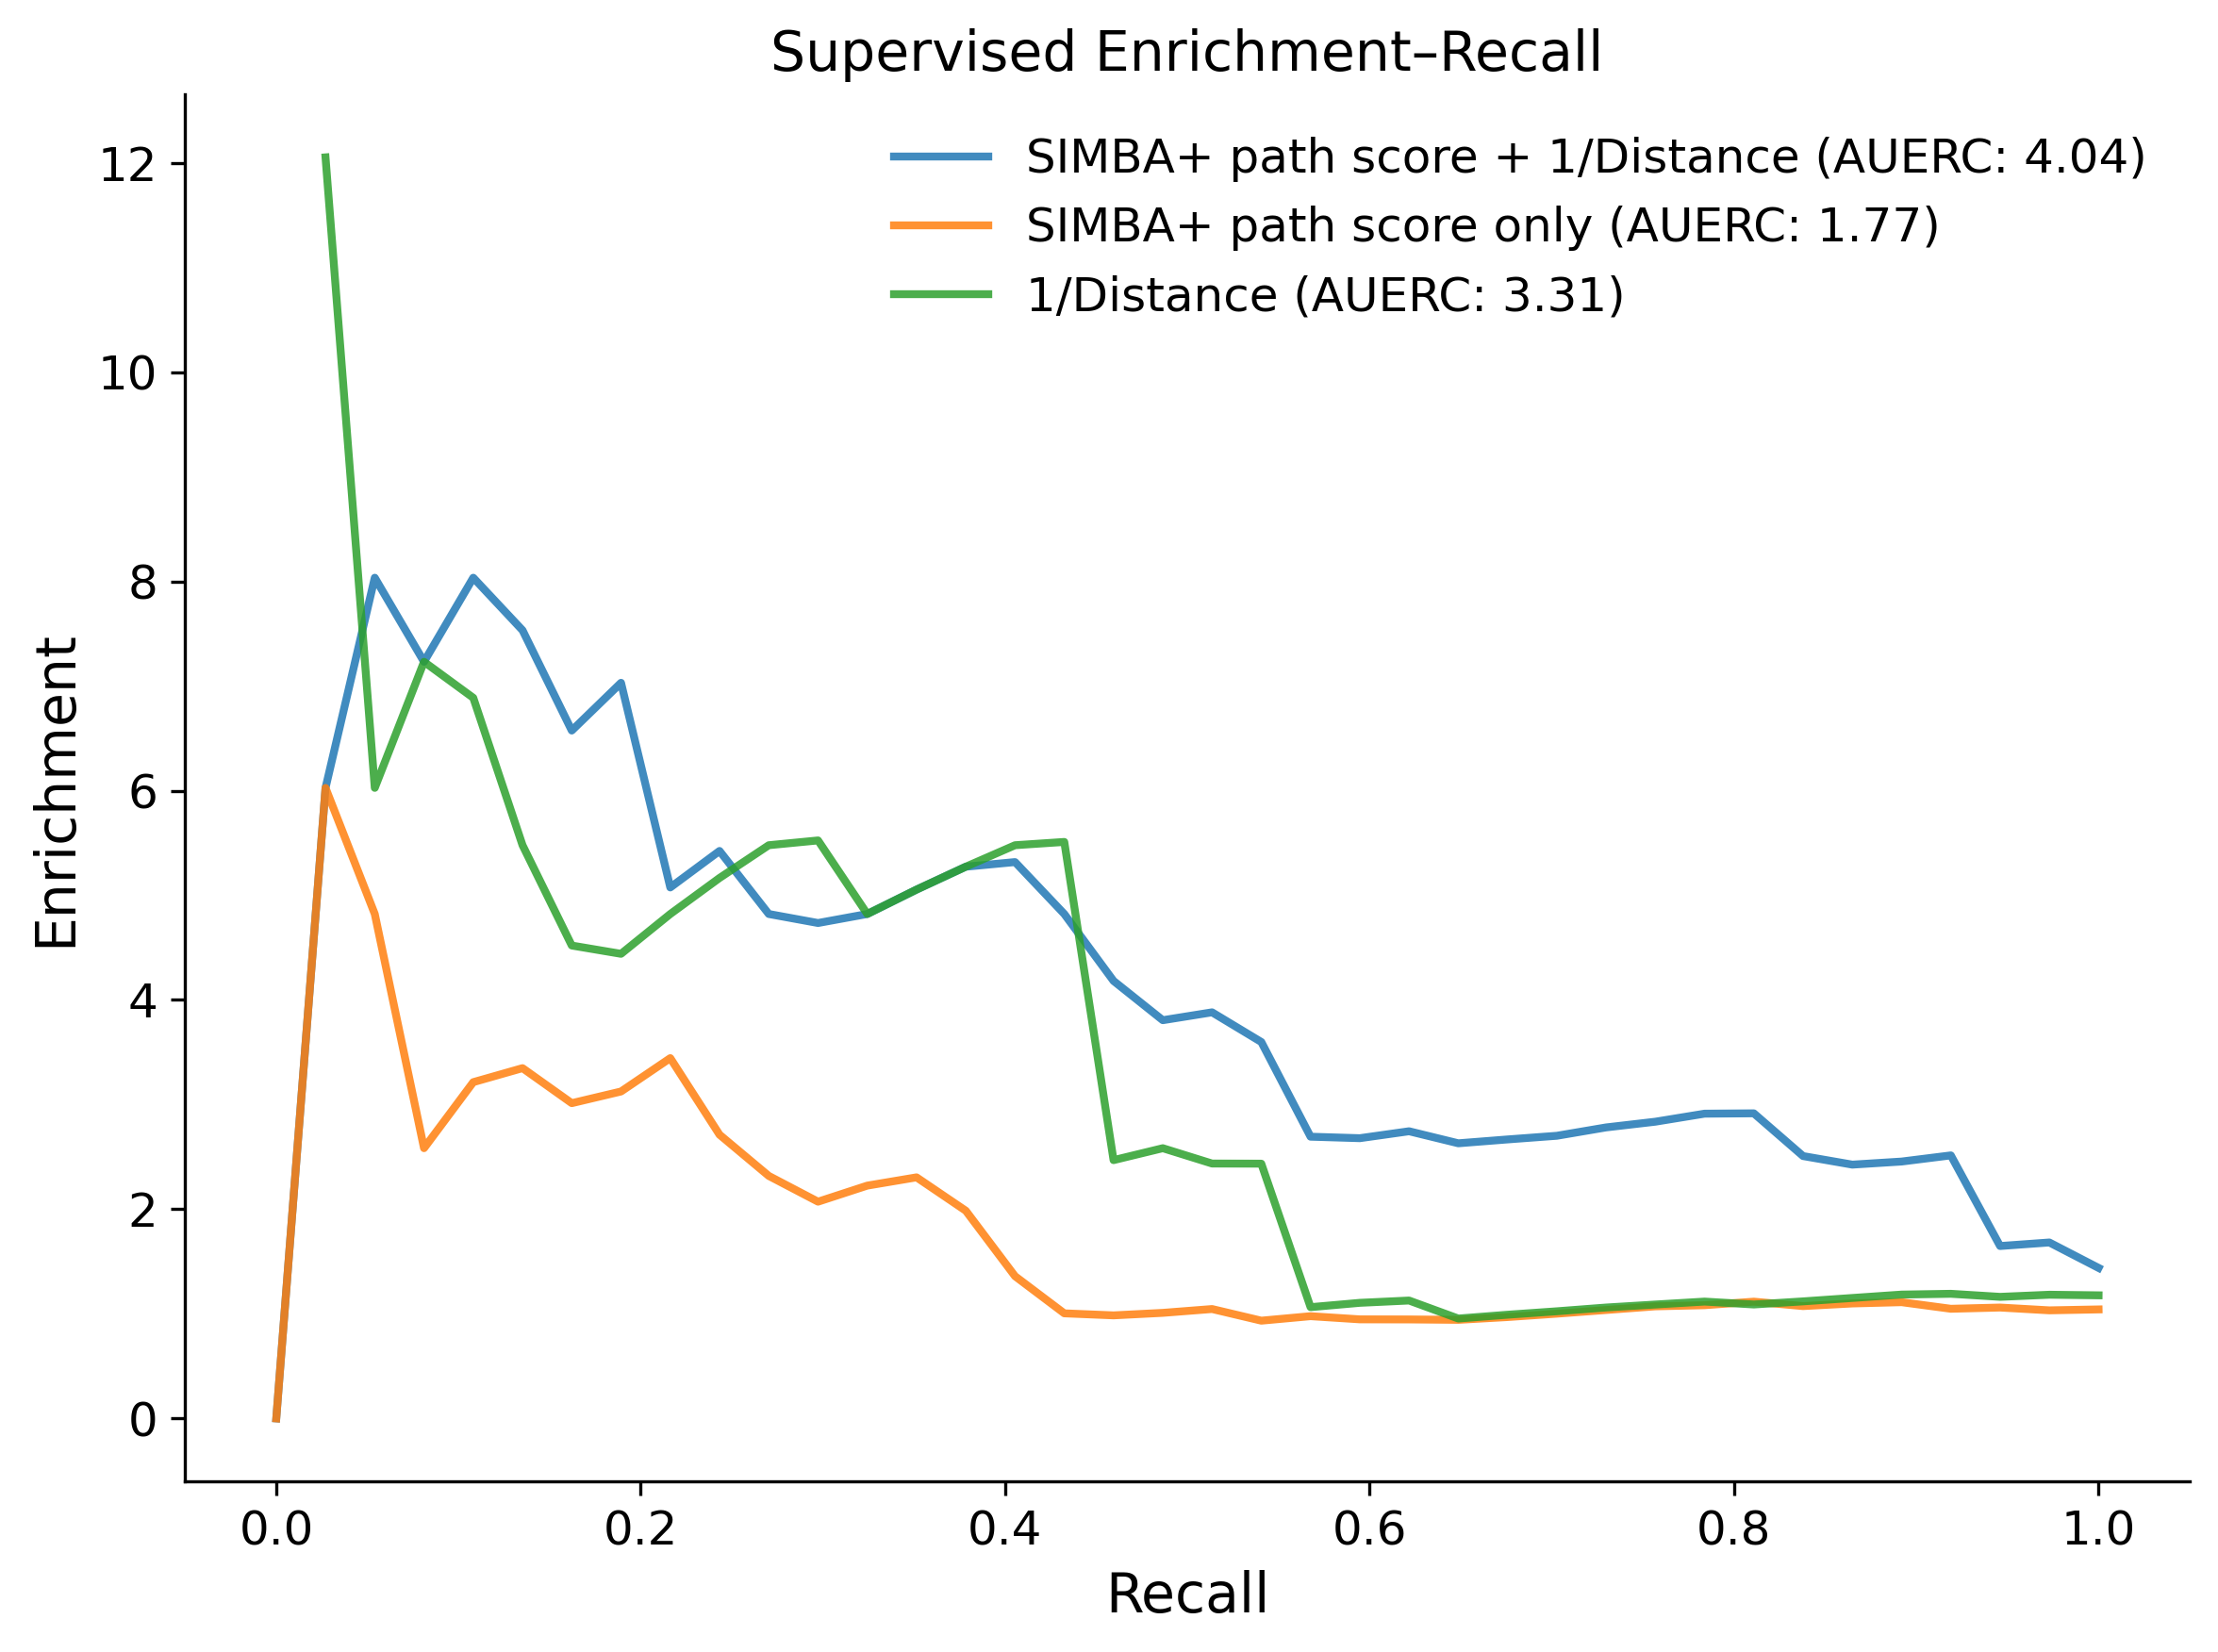

In [ ]:
# --- Supervised plot ---
preds_df.rename(columns={'true_label':'gold'}, inplace=True)
plot_utils.plot_supervised(
    preds_df,
    columns_and_labels=columns_and_labels,
    save_path="../results/crispr_supervised.pdf"
)

Saved figure → ../results/crispr_unsupervised.pdf


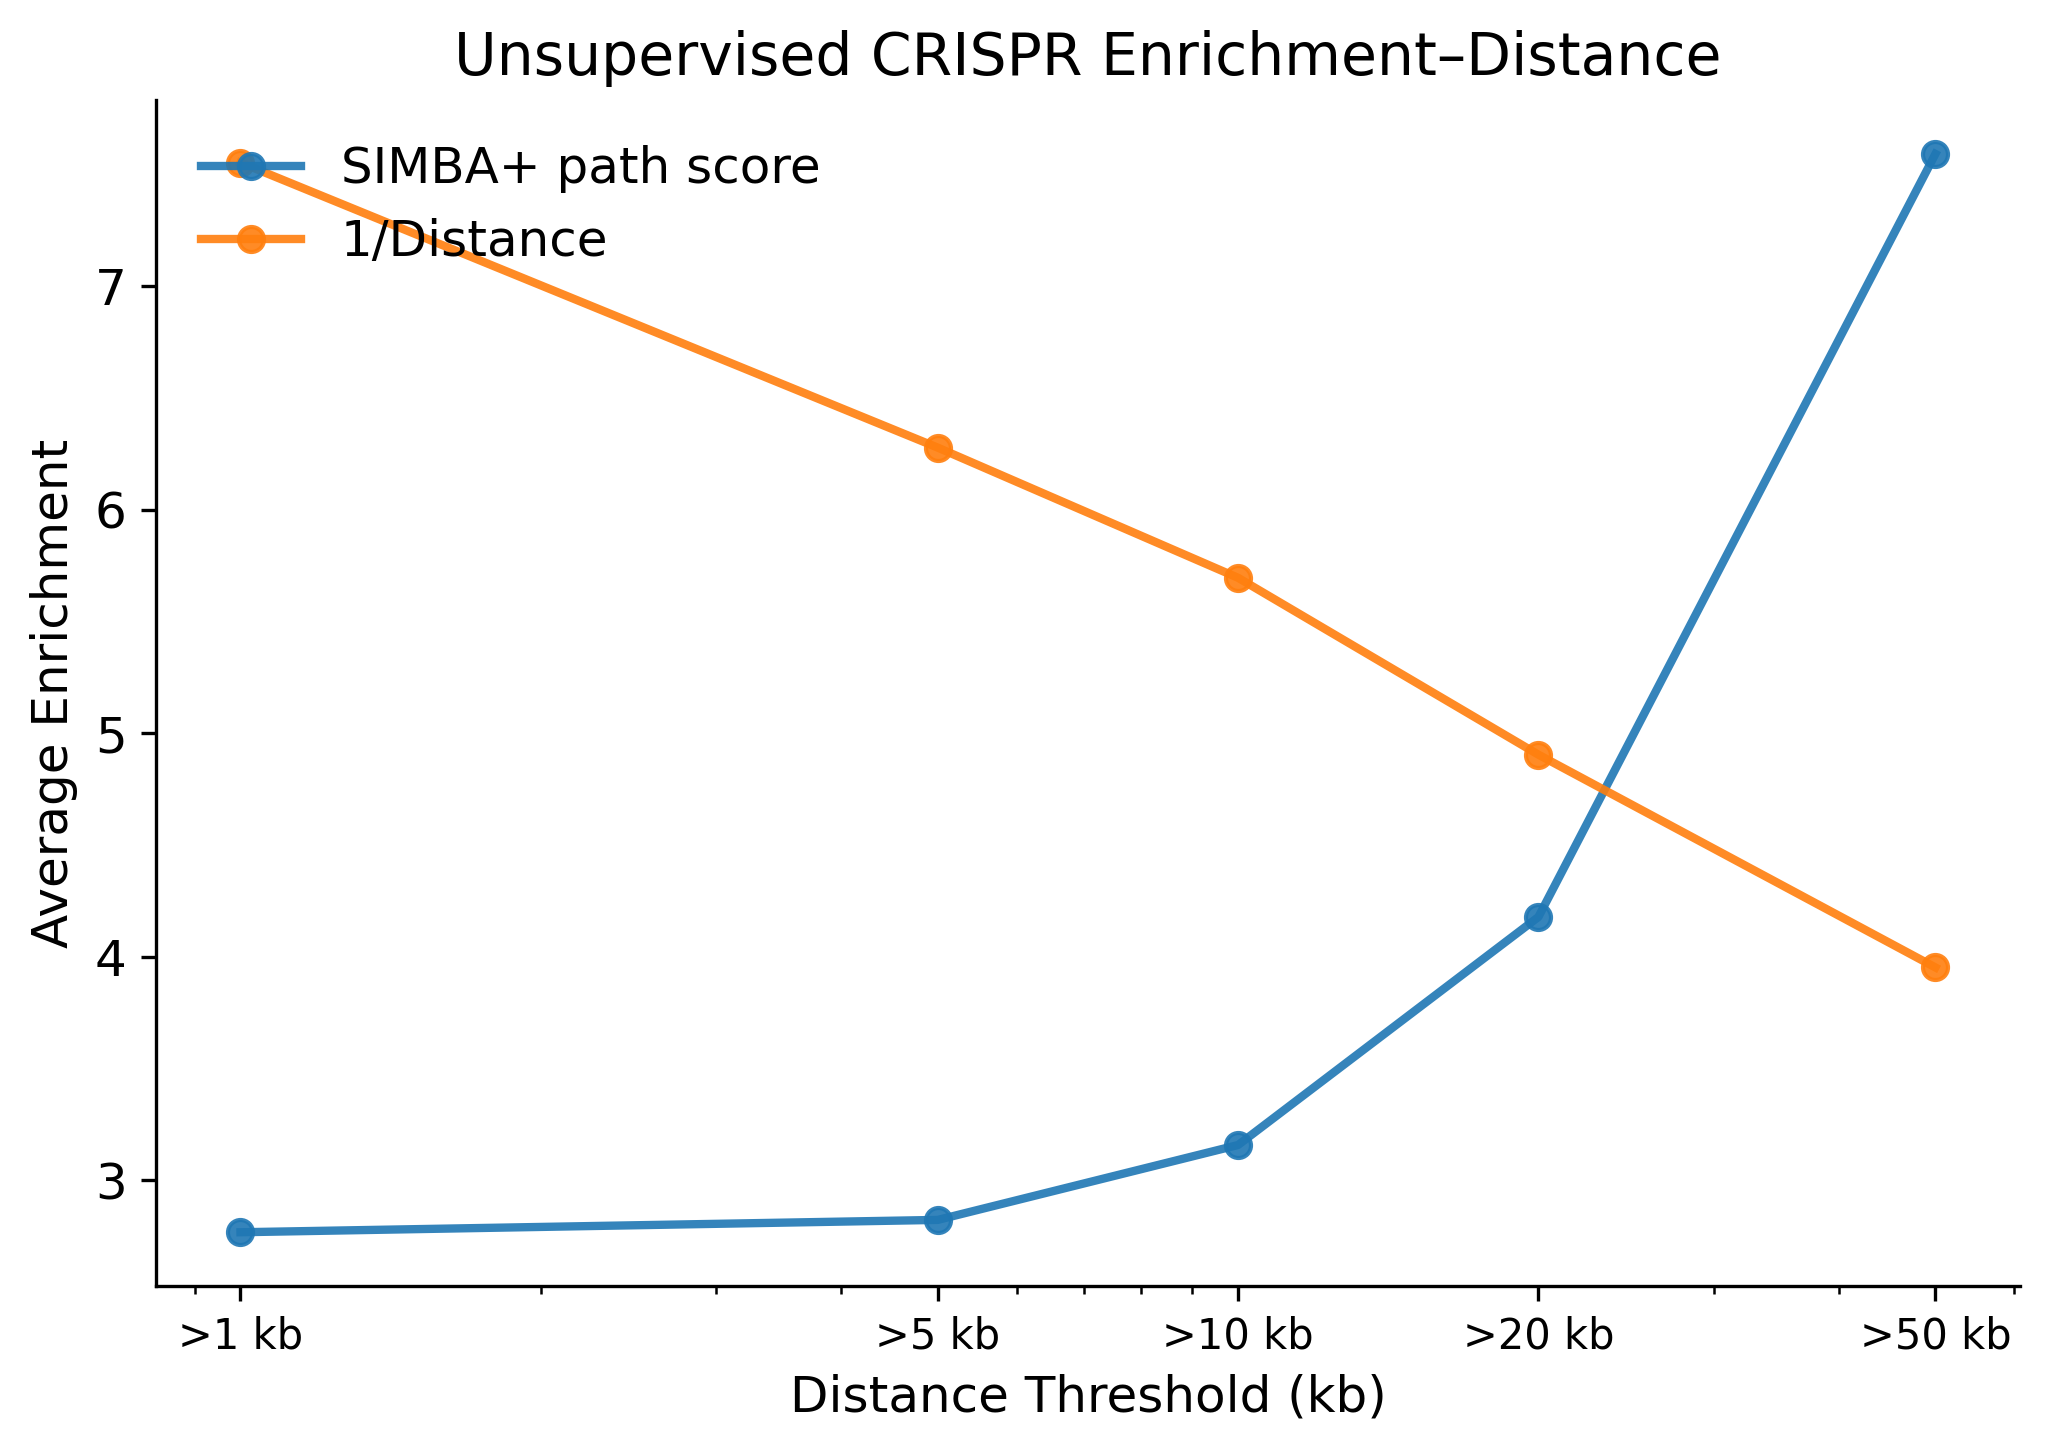

In [3]:
# Unsupervised distance plot
thresholds = [1000, 5000, 10000, 20000, 50000]
datasets = [crispr_eval_with_features]
dataset_names = ['crispr']
columns_and_labels=[
        ('SIMBA+ path score', 'SIMBA+_path_score'),
        ('1/Distance', '1/Distance'),
    ]

# add gold column
crispr_eval_with_features['gold'] = crispr_eval_with_features['label']
plot_utils.plot_unsupervised(
    crispr_eval_with_features, columns_and_labels,
    thresholds, save_fig=True, save_path="../results/crispr_unsupervised.pdf"
)
